## Creation of knockoffs from Spec2Vec embeddings


load files with spectra, put your own path

In [1]:
import numpy as np
import os
import sys
from matchms.importing import load_from_json
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument


folder_name = 'C:\\Users\\Gosia\\Desktop'
json_file_name = os.path.join(folder_name,'FDR-datsets', 'specs.json')
sys.path.append(os.path.join(folder_name,'FDR-Metabolomics', 'src'))

spectrums = load_from_json(json_file_name)

Optional: preprocessing with MatchMS

In [2]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

def post_process_classical(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = select_by_relative_intensity(s, intensity_from=0.01, intensity_to=1.0)
    return s

# apply filters to the data
spectrums_classical = [post_process_classical(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums_classical = [s for s in spectrums_classical if s is not None]

print("{} remaining spectra.".format(len(spectrums_classical)))

95320 remaining spectra.


In [4]:
import bisect
# a new filter to check if there is a fragment within N ppm of the precursor
def has_frag(spectrum, mz, tol, tol_units='absolute'):
    if tol_units == 'ppm':
        di = tol_ppm*mz/1e6
    else:
        di = tol
    min_mz = mz - di
    max_mz = mz + di
    pos = bisect.bisect_right(spectrum.peaks[0], min_mz)
    pos2 = bisect.bisect_right(spectrum.peaks[0], max_mz)
    if pos == pos2:
        return None
    else:
        max_pos = pos + np.argmax(spectrum.peaks[1][pos:pos2])
        return (spectrum.peaks[0][max_pos], spectrum.peaks[1][max_pos])

In [5]:
spectrums = [s for s in spectrums_classical if has_frag(s, s.metadata['precursor_mz'], 0.2)  is not None]

End of optional preprocessing

Creating a mapping of the inchi key prefixes to the spectrums in order to identify matching spectra

In [3]:
inchi_dict = {}
for s in spectrums:
    ik = s.metadata['inchikey_inchi']
    init_ik = ik.split('-')[0]
    if not init_ik in inchi_dict:
        inchi_dict[init_ik] = [s]
    else:
        inchi_dict[init_ik].append(s)

Dividing the spectra into library and queries

In [4]:
# choosing queries from multis ensures a possible true match
singletons = set([i for i,v in inchi_dict.items() if len(v) == 1])
multis = set([i for i,v in inchi_dict.items() if len(v) > 1])
print(len(singletons), len(multis))

2668 1890


In [5]:
query_size = 1500
library_size = 2500

Building the library with matching queries plus noise

In [6]:
query_and_library_inchis = np.random.choice(list(multis), size=query_size, replace=False)
library_noise_inchis = np.random.choice(list(singletons), size=library_size-query_size, replace=False)
spectrums_query = []
spectrums_lib = []
for inchi in query_and_library_inchis:
    query_spectrum, library_spectrum = np.random.choice(inchi_dict[inchi], size=2, replace=False)
    spectrums_query.append(query_spectrum)
    spectrums_lib.append(library_spectrum)
for inchi in library_noise_inchis:
    library_spectrum = np.random.choice(inchi_dict[inchi], size=1, replace=False)
    spectrums_lib.append(library_spectrum[0])

Create spectrum "documents"

In [7]:
documents_query = [SpectrumDocument(s, n_decimals=2) for s in spectrums_query]
documents_lib = [SpectrumDocument(s, n_decimals=2) for s in spectrums_lib]

Load pretrained model

In [8]:
import gensim
model_file = os.path.join('C:\\Users\\Gosia\\Desktop\\trained_models_1\\spec2vec_size_170.model')
model = gensim.models.Word2Vec.load(model_file)


## Creation of knockoffs

In [9]:
from knockoffs import generate_knockoffs, evaluate_knockoff_performance
knockoff_documents = generate_knockoffs(model,documents_lib,allowed_missing_percentage=30)

Embedding vector size: 170


Calculation of true/estimated q-values for knockoffs

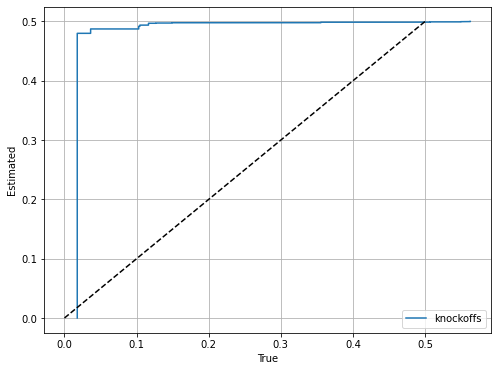

In [10]:
q_list_true, q_list_estimated = evaluate_knockoff_performance(documents_lib, documents_query, knockoff_documents, model,allowed_missing_percentage=30)

In [37]:
#TODO: plot these two separately
q_list_estimated


[(0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, False, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 1.0),
 (0.0, False, 1.0),
 (0.0, True, 1.0),
 (0.0, True, 0.9999999460532766),
 (0.0, True, 0.9999999407061283),
 (0.0, True, 0.9999998899355638),
 (0.0, True, 0.9999998375165375),
 (0.0, True, 0.9999998235252647),
 (0.0, True, 0.9999998195037088),
 (0.0, True, 0.999999771436696),
 (0.0, True, 0.9999997704482645),
 (0.0, True, 0.9999997064602226),
 (0.0, True, 0.9999995468512881),
 (0.0, True, 0.9999995249670911),


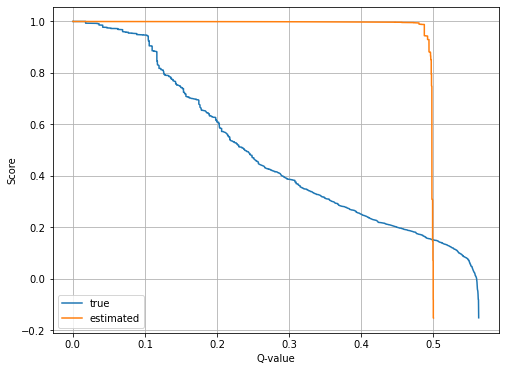

In [36]:
import pylab as plt
plt.figure(figsize=(8,6))
q_true, _, score = zip(*q_list_true)
plt.plot(q_true, score, label='true')
q_est, _, score_est = zip(*q_list_estimated)
plt.plot(q_est, score_est, label='estimated')
#plt.plot([0,0.5], [0,0.5], 'k--')
plt.xlabel('Q-value')
plt.ylabel('Score')
plt.legend()
plt.grid()